# Project 2: Multilayer Perceptron

Luke Ehrisman, Ben Williams

a. Load and preprocess the dataset
b. Train and test MLP model on dataset while tunning parameters to develop
multiple candidates
c. Evaluate models using appropriate metrics
d. Select most promising model
e. Predict response variable for validation inputs by using most promising moddel

In [241]:
import pandas as pd
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import optuna

SEED = 123
np.random.seed(SEED)

a. Load and preprocess the dataset

In [242]:
# import preprocessed datasets (from Project 1)
df = pd.read_csv("data/processed_adult_data.csv")

# assign features and target
X = df.drop('income', axis=1).values
y = df['income'].values

# encode target to integers (e.g. 0/1)
le = LabelEncoder()
y = le.fit_transform(y)

# scale features for stability
scaler = StandardScaler()
X = scaler.fit_transform(X)

# create train, test, and validation datasets
X_temp, X_valid, y_temp, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=SEED, stratify=y_temp)

# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

b. Train and test MLP model on dataset while tunning parameters to develop
multiple candidates

In [243]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)

        # Hidden layer
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # Output layer
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_loss__dw_out = np.dot(delta_out.T, a_h)
        d_loss__db_out = np.sum(delta_out, axis=0)

        d_loss__a_h = np.dot(delta_out, self.weight_out)
        d_a_h__d_z_h = a_h * (1. - a_h)

        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, x)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h


def compute_mse_and_acc(nnet, X, y, num_labels=2):
    _, probas = nnet.forward(X)
    predicted_labels = np.argmax(probas, axis=1)
    onehot_targets = int_to_onehot(y, num_labels=num_labels)
    mse = np.mean((onehot_targets - probas)**2)
    acc = np.mean(predicted_labels == y)
    return mse, acc

def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test,
          num_epochs, learning_rate=0.1, verbose=True):

    epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_test_acc = [], [], [], []

    for e in range(num_epochs):
        a_h, a_out = model.forward(X_train)
        d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
            model.backward(X_train, a_h, a_out, y_train)

        model.weight_h -= learning_rate * d_loss__d_w_h
        model.bias_h -= learning_rate * d_loss__d_b_h
        model.weight_out -= learning_rate * d_loss__d_w_out
        model.bias_out -= learning_rate * d_loss__d_b_out

        # Evaluation
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)

        epoch_loss.append(train_mse)
        epoch_train_acc.append(train_acc * 100)
        epoch_valid_acc.append(valid_acc * 100)
        epoch_test_acc.append(test_acc * 100)

    if verbose:
        print(f"Epoch: {e+1:03d}/{num_epochs:03d} "
              f"| Train Acc: {train_acc*100:.2f}% "
              f"| Valid Acc: {valid_acc*100:.2f}% "
              f"| Test Acc: {test_acc*100:.2f}%")

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_test_acc

In [244]:
# Optuna objective function
def objective(trial):
    num_hidden = trial.suggest_int("num_hidden", 10, 200)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    num_epochs = trial.suggest_int("num_epochs", 20, 100)

    num_classes = len(np.unique(y_train))
    model = NeuralNetMLP(num_features=X_train.shape[1],
                         num_hidden=num_hidden,
                         num_classes=num_classes,
                         random_seed=SEED)

    epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_test_acc = train(
        model=model,
        X_train=X_train, y_train=y_train,
        X_valid=X_valid, y_valid=y_valid,
        X_test=X_test, y_test=y_test,
        num_epochs=num_epochs,
        learning_rate=learning_rate
    )

    best_val_acc = max(epoch_valid_acc)
    return best_val_acc

In [245]:
# Run Optuna study
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

n_trials = 40
print(f"Starting hyperparameter optimization with Optuna... [{n_trials} trials]")
study.optimize(objective, n_trials=n_trials)

# Best finding
print("\nBest trial:")
trial = study.best_trial
print(f"  Validation Accuracy: {trial.value:.2f}%")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

Starting hyperparameter optimization with Optuna... [40 trials]
Epoch: 038/038 | Train Acc: 75.92% | Valid Acc: 75.93% | Test Acc: 75.93%
Epoch: 054/054 | Train Acc: 75.94% | Valid Acc: 75.93% | Test Acc: 75.94%
Epoch: 058/058 | Train Acc: 75.98% | Valid Acc: 75.93% | Test Acc: 75.93%
Epoch: 079/079 | Train Acc: 75.93% | Valid Acc: 75.93% | Test Acc: 75.93%
Epoch: 052/052 | Train Acc: 75.83% | Valid Acc: 75.87% | Test Acc: 75.82%
Epoch: 034/034 | Train Acc: 65.32% | Valid Acc: 65.51% | Test Acc: 65.18%
Epoch: 071/071 | Train Acc: 75.93% | Valid Acc: 75.93% | Test Acc: 75.93%
Epoch: 069/069 | Train Acc: 77.96% | Valid Acc: 78.50% | Test Acc: 77.85%
Epoch: 049/049 | Train Acc: 75.92% | Valid Acc: 75.93% | Test Acc: 75.90%
Epoch: 071/071 | Train Acc: 75.93% | Valid Acc: 75.93% | Test Acc: 75.93%
Epoch: 099/099 | Train Acc: 75.93% | Valid Acc: 75.93% | Test Acc: 75.93%
Epoch: 020/020 | Train Acc: 76.39% | Valid Acc: 76.31% | Test Acc: 76.30%
Epoch: 021/021 | Train Acc: 75.93% | Valid Acc: 

c. Evaluate models using appropriate metrics

In [246]:
# Retrain best model
best_params = trial.params

X_combined = np.vstack((X_train, X_valid))
y_combined = np.hstack((y_train, y_valid))

best_model = NeuralNetMLP(
    num_features=X_combined.shape[1],
    num_hidden=best_params["num_hidden"],
    num_classes=len(np.unique(y_combined))
)

In [247]:
mse, acc = compute_mse_and_acc(best_model, X_test, y_test)
print(f'Initial test MSE: {mse:.1f}')

Initial test MSE: 0.3


In [248]:
epoch_loss, epoch_train_acc, _, epoch_test_acc = train(
    best_model,
    X_train=X_combined, y_train=y_combined,
    X_valid=X_test, y_valid=y_test,  # placeholders for validation
    X_test=X_test, y_test=y_test,
    num_epochs=best_params["num_epochs"],
    learning_rate=best_params["learning_rate"],
    verbose=False
)

print(f"\nFinal test accuracy: {max(epoch_test_acc):.2f}%")


Final test accuracy: 83.51%


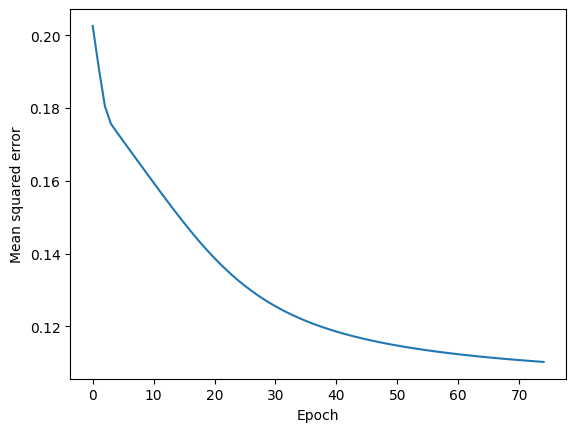

In [249]:
# evaluate MLP with minibatch performance
# plot Epoch vs MSE
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

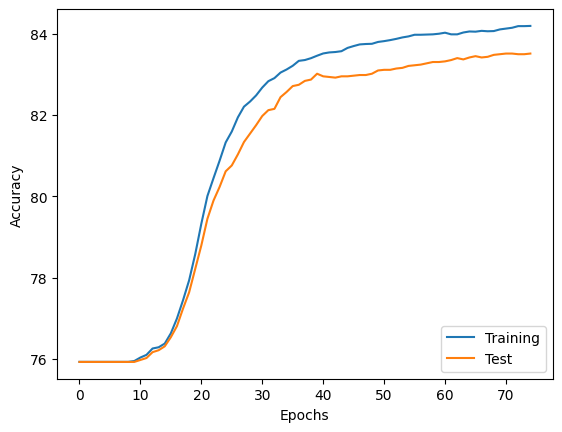

In [250]:
# plot Epoch vs accuracy for training and validation test
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_test_acc)), epoch_test_acc,
         label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [251]:
# look at the accuracy of the validation dataset (i.e., new data)
valid_mse, valid_acc = compute_mse_and_acc(best_model, X_valid, y_valid)
print(f'Validation accuracy: {valid_acc*100:.2f}%')

Validation accuracy: 84.80%


d. Select most promising model

In [252]:
# -----------------------------
# Print best model info
# -----------------------------
print("\n===============================")
print("BEST MODEL DETAILS")
print("===============================")
print(f"Validation Accuracy: {trial.value:.2f}%")
for key, value in trial.params.items():
    print(f"{key}: {value}")

# Print model architecture summary
print("\nModel architecture:")
print(f"Input features:  {X_combined.shape[1]}")
print(f"Hidden neurons:  {best_params['num_hidden']}")
print(f"Output classes:  {len(np.unique(y_combined))}")

print("\nHidden layer weights shape:", best_model.weight_h.shape)
print("Hidden layer bias shape:", best_model.bias_h.shape)
print("Output layer weights shape:", best_model.weight_out.shape)
print("Output layer bias shape:", best_model.bias_out.shape)

print("\nSample of first 5 hidden weights:\n", best_model.weight_h[:5])
print("\nSample of output weights:\n", best_model.weight_out[:5])


BEST MODEL DETAILS
Validation Accuracy: 84.74%
num_hidden: 73
learning_rate: 0.8201774843085462
num_epochs: 75

Model architecture:
Input features:  108
Hidden neurons:  73
Output classes:  2

Hidden layer weights shape: (73, 108)
Hidden layer bias shape: (73,)
Output layer weights shape: (2, 73)
Output layer bias shape: (2,)

Sample of first 5 hidden weights:
 [[-1.59709641e-01  8.90203132e-02 -4.35660238e-02 -2.16327781e-01
  -9.78652741e-02  1.01403009e-01 -2.24629994e-01 -7.00082482e-02
   1.21061697e-01 -8.58024881e-02 -6.91022928e-02 -3.28488775e-02
   1.61445054e-01 -4.76281161e-02 -3.66498453e-02 -2.49220778e-02
   2.38430972e-01  2.17191695e-01  1.05065965e-01  4.93932453e-02
   8.88304537e-02  1.65090995e-01 -8.75960979e-02  9.99864966e-02
  -1.51213472e-01 -9.29736075e-02  1.27772252e-01 -1.78152617e-01
  -9.44424337e-03 -1.31729889e-01 -2.57520327e-02 -2.42614327e-01
  -1.77409292e-01 -1.62266965e-01  1.00229465e-01  4.37769997e-02
   1.42907940e-02  7.63729850e-02 -6.9894

In [253]:
# Ensure predictions folder exists
os.makedirs("predictions", exist_ok=True)

# Compute predictions using the best Optuna-tuned model
_, probas = best_model.forward(X_test)
predicted_labels = np.argmax(probas, axis=1)

# Inverse transform predicted labels if you used a LabelEncoder before
predicted_income = le.inverse_transform(predicted_labels)
actual_income = le.inverse_transform(y_test)

# Build prediction DataFrame
pred_df = pd.DataFrame({
    'Predicted_Income': predicted_income,
    'Actual_Income': actual_income,
    'Correct': predicted_labels == y_test
})

# Save to CSV
# output_path = "predictions/adult_income_predictions.csv"
# pred_df.to_csv(output_path, index=False)

# Compute and display accuracy
accuracy = (predicted_labels == y_test).mean() * 100
# print(f"\nPredictions saved to '{output_path}'")
print(f"Test accuracy from predictions: {accuracy:.2f}%")

# Optional: display first few predictions
print("\nSample predictions:")
print(pred_df.head())

Test accuracy from predictions: 83.51%

Sample predictions:
  Predicted_Income Actual_Income  Correct
0             >50K         <=50K    False
1            <=50K         <=50K     True
2            <=50K         <=50K     True
3             >50K          >50K     True
4            <=50K         <=50K     True


In [254]:
num_correct = (pred_df['Predicted_Income'] == pred_df['Actual_Income']).sum()
num_total = len(pred_df)
print(f"Correct: {num_correct}/{num_total} ({num_correct / num_total * 100:.2f}%)")

Correct: 5221/6252 (83.51%)


e. Predict response variable for validation inputs by using most promising model

In [255]:
# Validation Data Loading and Alignment
validation_data = pd.read_csv('data/processed_validation_inputs.csv')
X_validation = validation_data.copy()
missing_cols = ['workclass_Never-worked', 'native-country_Holand-Netherlands', 'native-country_Outlying-US(Guam-USVI-etc)']
for col in missing_cols:
    X_validation[col] = 0.0

# Re-order the columns to match the training data order
training_feature_cols = df.drop('income', axis=1).columns
X_validation = X_validation[training_feature_cols]
X_validation_np = X_validation.values.astype(np.float64)

# Make predictions from best model
_, probas = best_model.forward(X_validation_np)
predicted_labels = np.argmax(probas, axis=1)

# Inverse transform predictions
predicted_income = le.inverse_transform(predicted_labels)

# Save predictions
output_df = pd.DataFrame({
    "Index": validation_data.index,
    "Predicted_Income": predicted_income
})

# # Save the predictions to a CSV file
file_name = "./predictions/Group_15_MLP_PredictedOutputs.csv"
output_df.to_csv(file_name, index=False)
print(f"Predictions saved to {file_name} (index + prediction only)")
output_df.head()

Predictions saved to ./predictions/Group_15_MLP_PredictedOutputs.csv (index + prediction only)


,Index,Predicted_Income
0,0,<=50K
1,1,<=50K
2,2,<=50K
3,3,<=50K
4,4,<=50K


# Reflection and Conceptual Questions

A) Why did you choose the specific architecture (e.g., number of layers, activation functions) for each model?

B) How did you monitor and mitigate overfitting in your models?

C) What ethical concerns might arise from deploying models trained on these datasets?

Firstly, this dataset includes many sensitive attributes like sex, race, and marital status. If this model is trained freely, it may reproduce social biases. Other proxy variables, such as occupation or education, could also have the same reprocussions.

If the model is trained with these biases, then it could lead to real-world impacts on people's lives. If this model were to be used for employment screening, lending, insurance, or government policies, it oculd lead to severe systemic discrimination.

Finally, the model only represents a small portion of people. As seen below, the counts of race or sex are heavily skewed. If this dataset were to be used on other demographics or populations, it could cause unintended problems.

In [12]:
#Count total values in 'race' and 'sex' column in original csv
print(pd.read_csv("data/project_adult.csv")['race'].value_counts())
print("\n", pd.read_csv("data/project_adult.csv")['sex'].value_counts())


race
White                 22221
Black                  2525
Asian-Pac-Islander      846
Amer-Indian-Eskimo      240
Other                   216
Name: count, dtype: int64

 sex
Male      17403
Female     8645
Name: count, dtype: int64


D) Why are activation functions necessary in Neural Networks?

Activation functions are necessary mainly because they introduce nonlinearity into the network. Without a activation function, a neural network will always apply a linear transformation upon the data. However, when adding something like a ReLU  or Sigmoid, the model can be used to represent complex relationships. 

The other main function that activation functions have is converting outputs into usable forms. When the network finishes, it outputs random numbers based on its findings. When you apply an activation function to them, it turns them into something usable, like probabilities.